In [1]:
import matplotlib.pyplot as plt

def plot_gallery(images,title,h,w,n_row=3,n_col=4):
        
    '''
    打印图片
    images：list或者tuple，每一个元素对应一张图片
    title：list或者tuple，每一个元素对应一张图片的标题
    h:高度的像素数
    w:宽度像素数
    n_row：输出行数
    n_col：输出列数
    '''
    #指定整个绘图对象的宽度和高度
    plt.figure(figsize=(1.8*n_col,2.4*n_row))
    plt.subplots_adjust(bottom=0,left=.01,right=.99,top=.90,hspace=.35)    
    #绘制子图
    for i in range(n_row*n_col):
        #第i+1个子窗口 默认从1开始编号
        plt.subplot(n_row,n_col,i+1)
        #显示图片 传入height*width矩阵 
        plt.imshow(images[i].reshape((h,w)),cmap=plt.cm.gray)  #cmap Colormap 灰度 
        #设置标题
        plt.title(title[i],size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()
    
def title(Y_pred,Y_test,target_names,i):
    '''
    打印第i个测试样本对应的标题
    Y_pred：测试集预测结果集合 (分类标签集合)
    Y_test: 测试集真是结果集合 (分类标签集合)
    target_names:分类每个标签对应的名称
    i:第i个样本
    '''
    pred_name = target_names[Y_pred[i]].rsplit(' ',1)[-1]
    true_name = target_names[Y_test[i]].rsplit(' ',1)[-1]
    return 'predicted:%s\ntrue:    %s' %(pred_name,true_name)



In [3]:
import tensorflow as tf
import numpy as np
import random

'''
导入数据
'''
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST-data',one_hot=True)

print(type(mnist)) #<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>

print('Training data shape:',mnist.train.images.shape)           #Training data shape: (55000, 784)
print('Test data shape:',mnist.test.images.shape)                #Test data shape: (10000, 784)
print('Validation data shape:',mnist.validation.images.shape)    #Validation data shape: (5000, 784)
print('Training label shape:',mnist.train.labels.shape)          #Training label shape: (55000, 10)


Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
Training data shape: (55000, 784)
Test data shape: (10000, 784)
Validation data shape: (5000, 784)
Training label shape: (55000, 10)


Epoch 0 Training set cost 0.3509688675403595:
Epoch 1 Training set cost 0.27738749980926514:
Epoch 2 Training set cost 0.23484018445014954:
Epoch 3 Training set cost 0.20193077623844147:
Epoch 4 Training set cost 0.17526878416538239:
Epoch 5 Training set cost 0.1533273607492447:
Epoch 6 Training set cost 0.1352381706237793:
Epoch 7 Training set cost 0.12016846239566803:
Epoch 8 Training set cost 0.10745882242918015:
Epoch 9 Training set cost 0.09665225446224213:
输出权重维数：
(784, 1024)
(1024, 10)
输出偏置维数：
(1024,)
(10,)
准确率: 0.9664


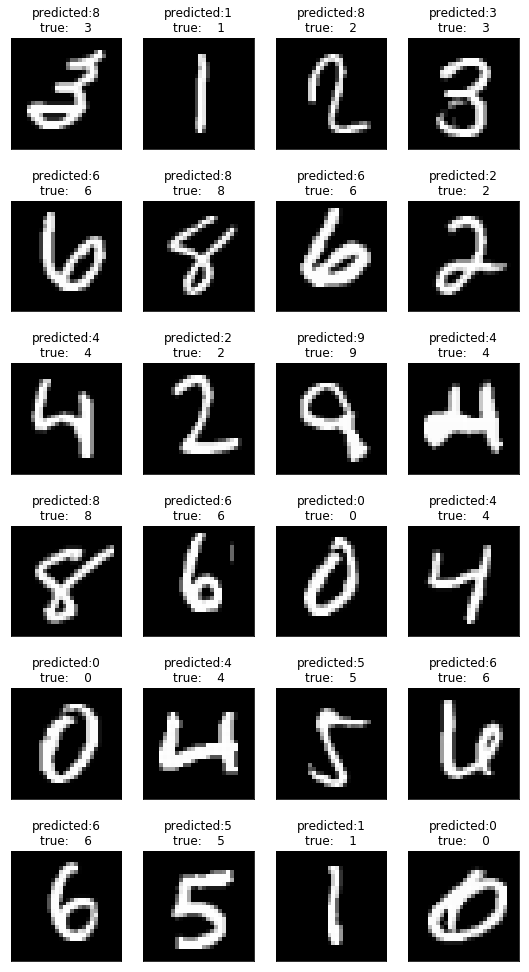

In [4]:
class network(object):   
    '''
    全连接神经网络
    '''
    def __init__(self,sizes):     
        '''
        op变量只需要初始化一遍就可以，在fit()中初始化
        sizes：list传入每层神经元个数
        '''
        #保存参数
        self.__sizes = sizes
        #神经网络每一层的神经元个数数组类型
        self.sizes = tf.placeholder(tf.int64,shape=[1,len(sizes)])
        #计算神经网络层数 包括输入层
        self.num_layer = tf.size(self.sizes)
        #随机初始化权重  第i层和i+1层之间的权重向量
        self.weights = [self.weight_variable(shape=(x,y)) for x,y in  zip(sizes[:-1],sizes[1:])]
        #随机初始化偏置  第i层的偏置向量  i=1...num_layers  注意不可以设置shape=(x,1)
        self.biases = [self.bias_variable(shape=[x,]) for x in sizes[1:]] 
        
        #输入样本和输出类别变量
        self.x_ = tf.placeholder(tf.float32,shape=[None,sizes[0]])
        self.y_ = tf.placeholder(tf.float32,shape=[None,sizes[-1]])
         
        #设置tensorflow对GPU使用按需分配
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True        
        self.sess = tf.InteractiveSession(config=config)
              
    
    
    def weight_variable(self,shape):
        '''
        初始化权值
        '''
        #使用截断式正太分布初始化权值   截断式即在正态分布基础上加以限制，以使生产的数据在一定范围上
        initial = tf.truncated_normal(shape,mean=0.0,stddev= 1.0/shape[0])    #方差为1/nin
        return tf.Variable(initial)

    def bias_variable(self,shape):
        '''
        初始化偏重
        '''
        initial =  tf.truncated_normal(shape,mean=0.0,stddev= 1.0/shape[0])    #方差为1/nin
        return tf.Variable(initial)
    
    def feedforward(self,x):                 
        '''
        构建阶段：前向反馈
        x:变量op,tf.placeholder()类型变量
        返回一个op
        '''
        #计算隐藏层
        output = x
        for i in range(len(self.__sizes)-1):
            b = self.biases[i]
            w = self.weights[i]
            if i != len(self.__sizes)-2 :
                output =  tf.nn.relu(tf.matmul(output,w) + b)
            else:
                output = tf.nn.softmax(tf.matmul(output,w) + b)
        return output
           
    def fit(self,training_x,training_y,learning_rate=0.001,batch_size=64,epochs=10):
        output = self.feedforward(self.x_)
         
         #代价函数 J =-(Σy.logaL)/n    .表示逐元素乘
        cost = tf.reduce_mean( -tf.reduce_sum(self.y_*tf.log(output),axis = 1))
         
         #求解
        train = tf.train.AdamOptimizer(learning_rate).minimize(cost)
         
         #使用会话执行图     
        
         #初始化变量 必须在train之后
        self.sess.run(tf.global_variables_initializer())  
          
         #训练集长度
        n = training_x.shape[0]         
         
         #开始迭代 使用Adam优化的随机梯度下降法
        for i in range(epochs):
              # 预取图像和label并随机打乱
            random.shuffle([training_x,training_y])   
            x_batches = [training_x[k:k+batch_size] for k in range(0,n,batch_size)]
            y_batches = [training_y[k:k+batch_size] for k in range(0,n,batch_size)]
                 
              #开始训练
            for x_batch,y_batch in zip(x_batches,y_batches):
                train.run(feed_dict={self.x_:x_batch,self.y_:y_batch})   
               
              #计算每一轮迭代后的误差 并打印
            train_cost = cost.eval(feed_dict={self.x_:training_x,self.y_:training_y}) 
            print('Epoch {0} Training set cost {1}:'.format(i,train_cost))
         
                
    def predict(self,test_x):        
        '''
        对输入test_x样本进行预测
        '''
        output = self.feedforward(self.x_)
        #使用会话执行图
        return output.eval(feed_dict={self.x_:test_x})
             
     
    def accuracy(self,x,y):
        '''
        返回值准确率
        x:测试样本集合
        y:测试类别集合
        '''
        output = self.feedforward(self.x_)
        correct = tf.equal(tf.argmax(output,1),tf.argmax(self.y_,1))       #返回一个数组 表示统计预测正确或者错误 
        accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))             #求准确率        
        #使用会话执行图
        return accuracy.eval(feed_dict={self.x_:x,self.y_:y})
    
    def cost(self,x,y):
        '''
        计算代价值
        '''
        #计算输出层
        output = self.feedforward(self.x_)         
        #代价函数 J =-(Σy.logaL)/n    .表示逐元素乘
        cost = tf.reduce_mean(-tf.reduce_sum(self.y_*tf.log(output),axis=1))
        #使用会话执行图
        return cost.eval(feed_dict={self.x_:x,self.y_:y})
    
#开始测试
nn = network([784,1024,10])
nn.fit(mnist.train.images,mnist.train.labels,0.0001,64,10)
weights = nn.sess.run(nn.weights)
print('输出权重维数：')
for weight in weights:
    print(weight.shape)
print('输出偏置维数：')
biases = nn.sess.run(nn.biases)
for biase in biases:
    print(biase.shape)
print('准确率:',nn.accuracy(mnist.test.images,mnist.test.labels))


#取24个样本，可视化显示预测效果
x_batch,y_batch = mnist.test.next_batch(batch_size = 24)   
#获取x_batch图像对象的数字标签
y_test = np.argmax(y_batch,1)
#获取预测结果
y_pred = np.argmax(nn.predict(x_batch),1)

#显示与分类标签0-9对应的名词
target_names = ['number 0','number 1','number 2','number 3','number 4','number 5','number 6','number 7','number 8','number 9']

#标题 
prediction_titles = [title(y_pred,y_test,target_names,i) for i in range(y_pred.shape[0])]
#打印图片
plot_gallery(x_batch,prediction_titles,28,28,6,4)
